In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from textwrap import wrap

pd.options.mode.copy_on_write = True

In [40]:
def calc_total_emissions(df):
    gasses = ["Kohlendioxid (CO2)", "Methan (CH4)", "Distickstoffmonoxid (N2O)", "Flüchtige Kohlenwasserstoffe ohne Methan (NMVOC)", "Feinstaub (10 µm)"]
    new_cols = ["economic_sector"] + gasses
    analyzed_df = df[new_cols]
    analyzed_df["total_emissions"] = df[gasses].sum(axis=1)
    analyzed_df["excluded_emissions"] = calc_excluded_emissions(df, gasses)
    new_col_order = ["economic_sector", "total_emissions", "excluded_emissions"] + gasses
    analyzed_df = analyzed_df[new_col_order]
    analyzed_df = analyzed_df.sort_values(by="total_emissions", ascending=False)
    return analyzed_df

def calc_excluded_emissions(df, included_gasses):
    columns_to_remove = ["year", "economic_sector"] + included_gasses
    excluded_gasses = [col for col in df.columns if col not in columns_to_remove]
    return df[excluded_gasses].sum(axis=1)

def calc_proportions(df):
    # emission from all sectors, from only included 5 gasses
    total_year_emission = df["total_emissions"].sum()
    # emission from all sectors, from excluded gasses
    total_excluded_year_emission = df["excluded_emissions"].sum()
    # all of the emissions in a year, from all gasses
    total = total_year_emission + total_excluded_year_emission
    df["proportions"] = (df["total_emissions"] / total).round(10)
    df["excluded_proportions"] = (df["excluded_emissions"] / total).round(2)
    return total_year_emission

def add_others_sector(df, rank=6):
    num_sectors = len(df)
    others_df = df.tail(num_sectors - rank - 1)
    sums = others_df.drop(columns=["economic_sector"]).sum()
    others_row = pd.DataFrame(data={'economic_sector': ['Others'], **sums.to_dict()})
    df_with_others = pd.concat([df.head(rank-1), others_row], ignore_index=True)
    df_with_others = df_with_others.sort_values(by="total_emissions", ascending=False)
    return df_with_others


def analyze_year(year, rank=6):
    filename = f"../data/Luftemissionen_{year}.csv"
    df = pd.read_csv(filename, delimiter=";")
    smaller_df = calc_total_emissions(df)
    df_to_analyze = add_others_sector(smaller_df, rank)
    calc_proportions(df_to_analyze)
    return df_to_analyze



In [41]:
def visualize(df):
    sns.set_style("darkgrid")
    palette = sns.color_palette("cubehelix")
    catp = (sns.catplot(data=df, x='economic_sector', y='proportions',
                    kind='bar',
                    hue="economic_sector",
                    palette=palette,
                    height=5,
                    aspect=19/6))
        
    catp.set_axis_labels("Economic Sectors", "Proportion", fontsize=14)
    plt.title("\n".join(wrap("Proportional Contribution of Each Sector to Total Air Emissions", 90)), fontsize=18)
    plt.tight_layout()
    catp.ax.set_yticks((0,0.10,0.20,0.30,0.40))
    plt.tight_layout()
    catp.ax.set_yticks((0,0.10,0.20,0.30,0.40))

    for ax in catp.axes.ravel():
        labels = ax.get_xticklabels()
        for v in labels:
            text = v.get_text()
            text = '\n'.join(wrap(text, 30))
            v.set_text(text)
        ax.set_xticklabels(labels)
        for c in ax.containers:
            ax.bar_label(c, label_type='edge')


In [42]:
def get_total_emissions(df, sector_name):
    return df.loc[df['economic_sector'] == sector_name, 'total_emissions'].values[0]

In [43]:
def get_proportions_for_year(df_dict, year, sectors):
    df = df_dict[year].set_index('economic_sector')
    return df.reindex(sectors)['proportions']

def compare_two_years_by_sector(year_dict, year_1, year_2, sectors=["Energie und Dienstleistungen der Energieversorgung", "Private Haushalte", "Others", "Metalle"]):
    comparison_df = pd.DataFrame(index=sectors)
    comparison_df[year_1] = get_proportions_for_year(year_dict, year_1, sectors)
    comparison_df[year_2] = get_proportions_for_year(year_dict, year_2, sectors)
    comparison_df.reset_index(inplace=True)
    comparison_df.rename(columns={'index': 'economic_sectors'}, inplace=True)
    comparison_long_df = pd.melt(comparison_df, id_vars=['economic_sectors'], var_name='year', value_name='proportions')


    sns.set_style("darkgrid")
    palette = sns.color_palette("cubehelix")
    plt.tight_layout()
    catp = sns.catplot(data=comparison_long_df, kind="bar", x="economic_sectors", y="proportions", hue="year", 
                    height=6, aspect=16/9, palette=palette)

    catp.set_axis_labels("Sectors", "Proportions", fontsize=12)
    catp.fig.suptitle("Comparison between years", fontsize=16)
    catp.set_titles("{col_name}")

    for ax in catp.axes.ravel():
            labels = ax.get_xticklabels()
            for v in labels:
                text = v.get_text()
                text = '\n'.join(wrap(text, 30))
                v.set_text(text)
            ax.set_xticklabels(labels)
            for c in ax.containers:
                ax.bar_label(c, label_type='edge')


In [44]:
year_dict = {}
for i in range(1995, 2020):
    year_dict[i] = analyze_year(i, 20)

In [45]:
def visualize_trend(dict_of_df, sector_name, limit):
    sns.set_style("darkgrid")
    plt.figure(figsize=(10, 5))

    total_dict = {}
    
    for year in dict_of_df.keys():
        total = get_total_emissions(dict_of_df[year], sector_name)
        total_dict[year] = total

    plot_df = pd.DataFrame(list(total_dict.items()), columns=['year', 'total_emissions'])

    lineplot = sns.lineplot(data=plot_df, x="year", y="total_emissions", marker='o', color='b')
    plt.ylim(0, limit)
    lineplot.set_xlabel("Year", fontsize=12)
    lineplot.set_ylabel("Total Emissions", fontsize=12)
    lineplot.set_title("\n".join(wrap(f"Emission Trend for {sector_name}", 60)), fontsize=16)

    # Customize tick labels and rotation
    plt.xticks(list(dict_of_df.keys()), rotation=45)

    plt.tight_layout()
    plt.show()

    return total_dict

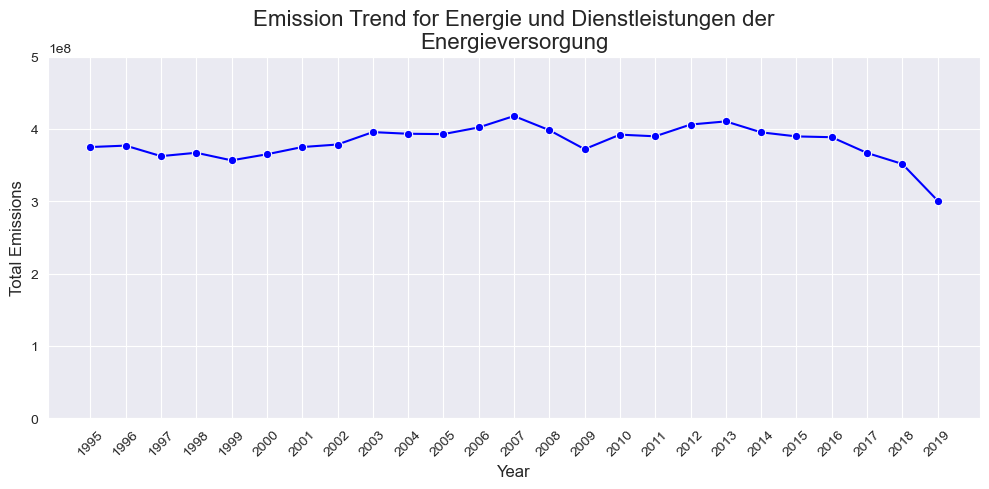

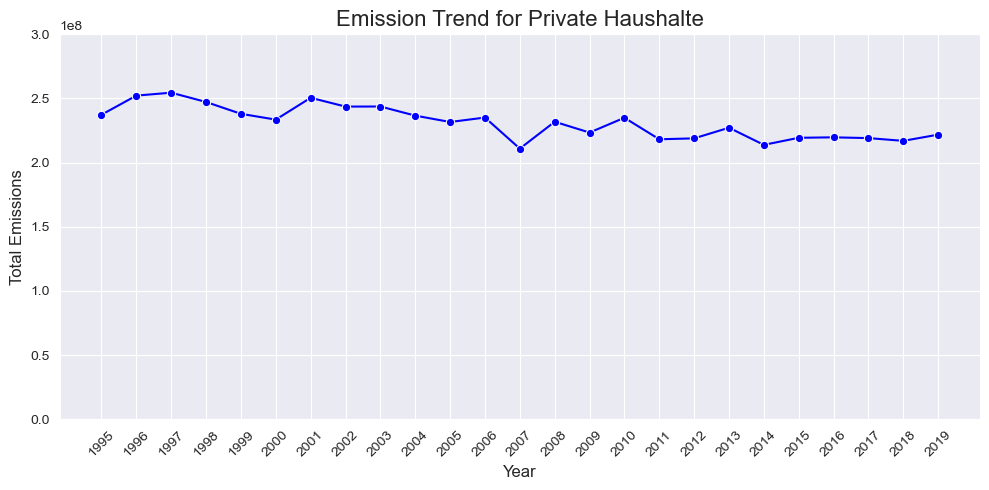

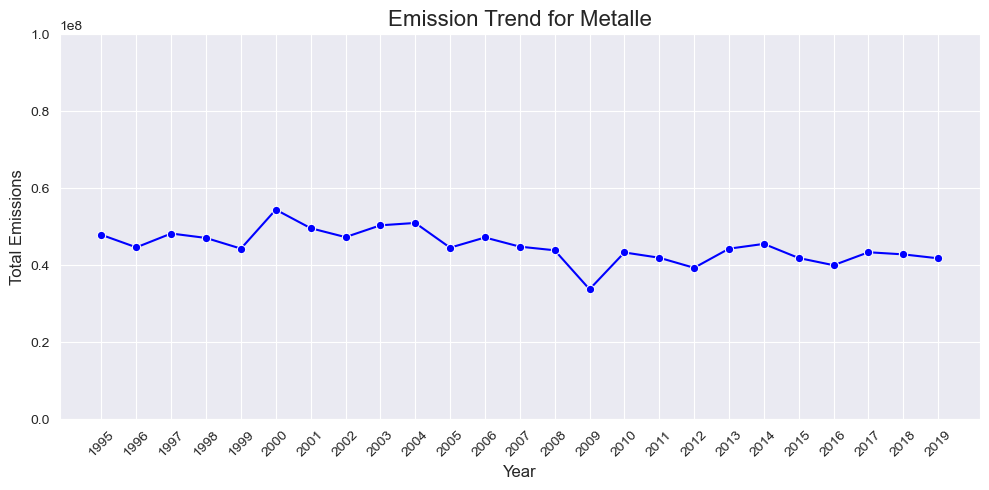

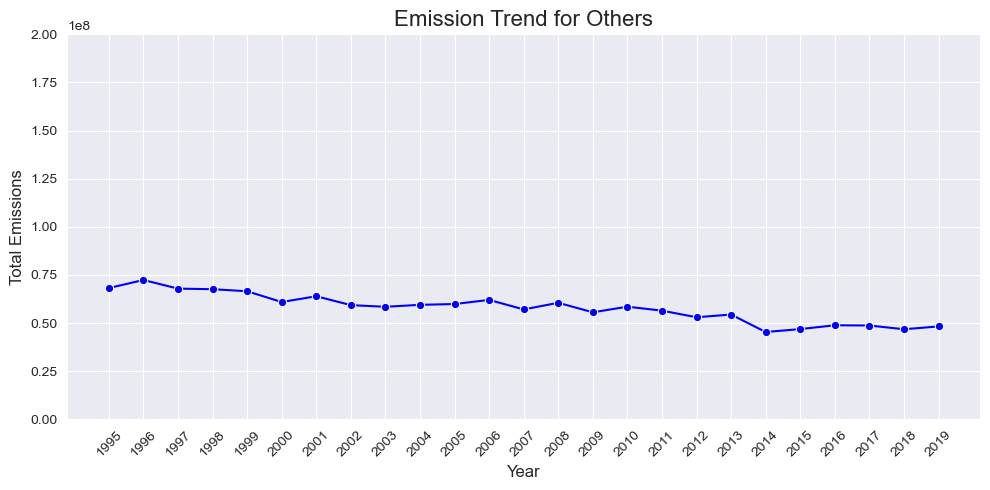

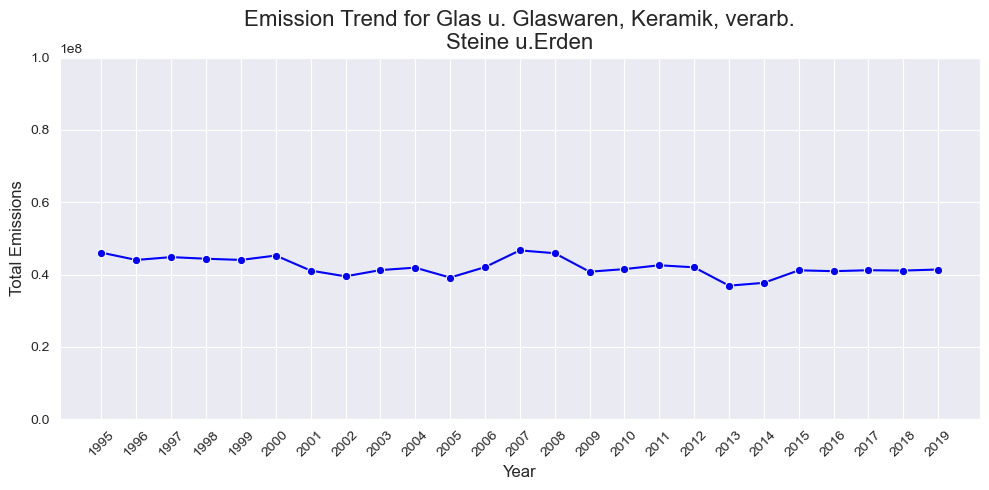

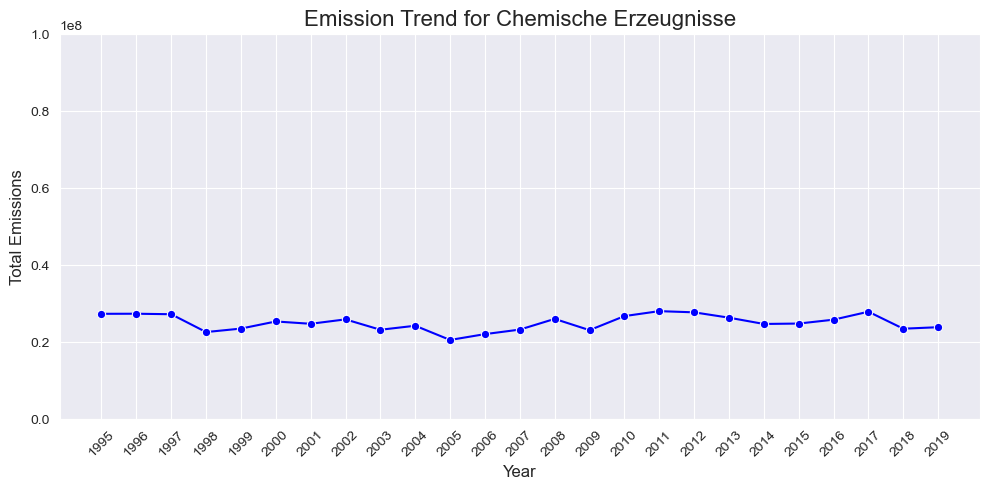

In [46]:
energy_comparison = visualize_trend(year_dict, "Energie und Dienstleistungen der Energieversorgung", limit=5e8)
private_hh_comparison = visualize_trend(year_dict, "Private Haushalte", limit=3e8)
metal_comparison = visualize_trend(year_dict, "Metalle", limit=1e8)
others_comparison = visualize_trend(year_dict, "Others", limit=2e8)
glass_comparison = visualize_trend(year_dict, "Glas u. Glaswaren, Keramik, verarb. Steine u.Erden", limit=1e8)
chemical_comparison = visualize_trend(year_dict, "Chemische Erzeugnisse", limit=1e8)

C:\Users\asude\AppData\Local\Temp\ipykernel_20320\1349885374.py:17: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  catp = sns.catplot(data=comparison_long_df, kind="bar", x="economic_sectors", y="proportions", hue="year",
C:\Users\asude\AppData\Local\Temp\ipykernel_20320\1349885374.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


<Figure size 640x480 with 0 Axes>

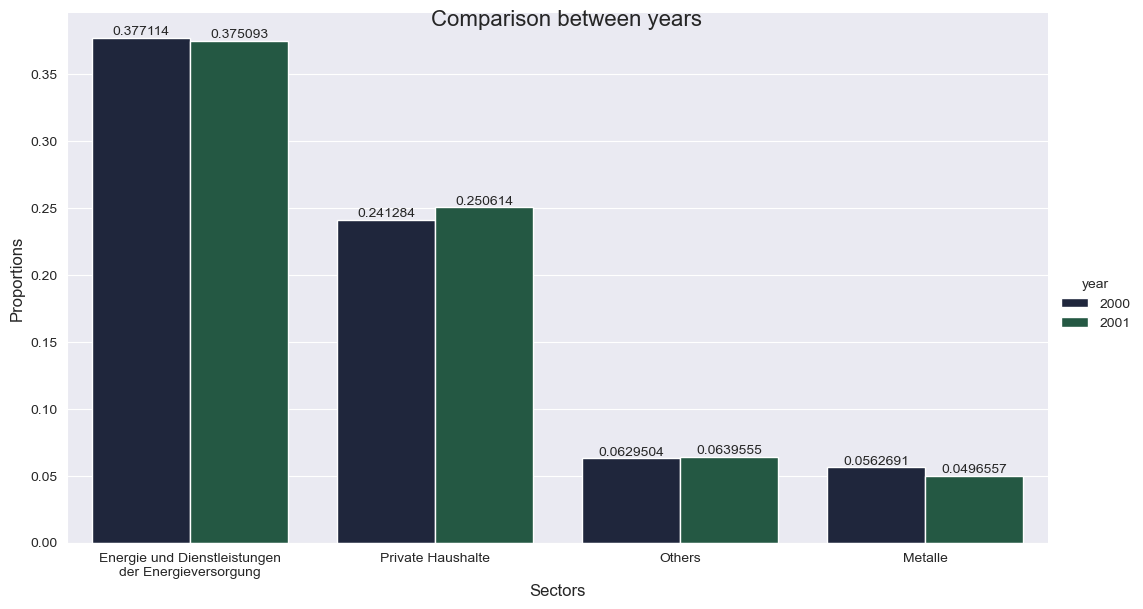

In [48]:
compare_two_years_by_sector(year_dict, 2000, 2001)

In [49]:
year_dict[2009]

,economic_sector,total_emissions,excluded_emissions,Kohlendioxid (CO2),Methan (CH4),Distickstoffmonoxid (N2O),Flüchtige Kohlenwasserstoffe ohne Methan (NMVOC),Feinstaub (10 µm),proportions,excluded_proportions
0,Energie und Dienstleistungen der Energieversor...,372076053,663735,371930031,116190,8705,11990,9137,0.391686,0.0
1,Private Haushalte,223455683,2972572,223004002,65410,3273,324536,58462,0.235233,0.0
19,Others,55593027,2923597,54980952,144208,2029,422912,42926,0.058523,0.0
2,"Glas u. Glaswaren, Keramik, verarb. Steine u.E...",40799106,95465,40791714,965,568,2593,3266,0.042949,0.0
3,Metalle,33780022,379239,33764457,2666,397,8569,3933,0.035560,0.0
4,Luftfahrtleistungen,28650334,201286,28636297,922,963,10643,1509,0.030160,0.0
5,Schifffahrtsleistungen,24721133,637334,24618178,236,1091,12850,88778,0.026024,0.0
6,Kokerei- und Mineralölerzeugnisse,24151429,73241,24129589,3444,310,16775,1311,0.025424,0.0
7,Chemische Erzeugnisse,23158425,157407,23050976,22207,32083,52439,720,0.024379,0.0
8,Landverkehrs- u. Transportleist. in Rohrfernleit.,17633464,745551,17469582,113665,488,13065,36664,0.018563,0.0


In [50]:
rank_dict = {}
for year in year_dict.keys():
    most_emitters = year_dict[year].head(6)[["economic_sector", "proportions"]].reset_index()
    most_emitters["year"] = year
    for sector in most_emitters["economic_sector"]:
        t = most_emitters[most_emitters["economic_sector"] == sector].index.item()
        if sector in rank_dict:
            rank_dict[sector] = t / 49
        else:
            rank_dict[sector] = t / 49

sorted(rank_dict.items(), key=lambda x:x[1])

[('Energie und Dienstleistungen der Energieversorgung', 0.0),
 ('Private Haushalte', 0.02040816326530612),
 ('Others', 0.04081632653061224),
 ('Metalle', 0.061224489795918366),
 ('Glas u. Glaswaren, Keramik, verarb. Steine u.Erden', 0.08163265306122448),
 ('Chemische Erzeugnisse', 0.10204081632653061),
 ('Kokerei- und Mineralölerzeugnisse', 0.10204081632653061),
 ('Schifffahrtsleistungen', 0.10204081632653061),
 ('Luftfahrtleistungen', 0.10204081632653061)]

Sectors who emit the most: Energie und Dienstleistungen der Energieversorgung, Private Haushalte, Metalle, Glas u. Glaswaren, Keramik, verarb. Steine u.Erden

C:\Users\asude\AppData\Local\Temp\ipykernel_20320\4158066370.py:4: UserWarning: 
The palette list has fewer values (6) than needed (20) and will cycle, which may produce an uninterpretable plot.
  catp = (sns.catplot(data=df, x='economic_sector', y='proportions',
C:\Users\asude\AppData\Local\Temp\ipykernel_20320\4158066370.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


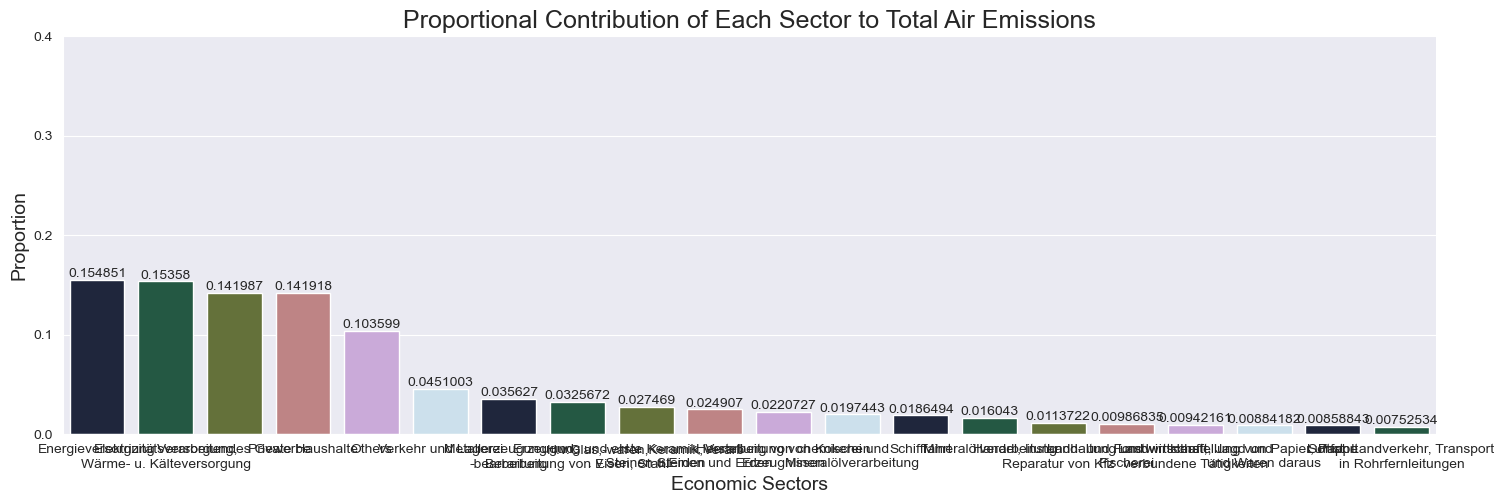

In [51]:
def analyze_2020_2021():
    file_2020 = f"../data/Luftemissionen_2020.csv"
    file_2021 = f"../data/Luftemissionen_2020.csv"
    year_2020 = pd.read_csv(file_2020, delimiter=";")
    year_2021 = pd.read_csv(file_2021, delimiter=";")
    

year_2020 = analyze_year(2020, 20)
year_2021 = analyze_year(2021, 20)
visualize(year_2020)

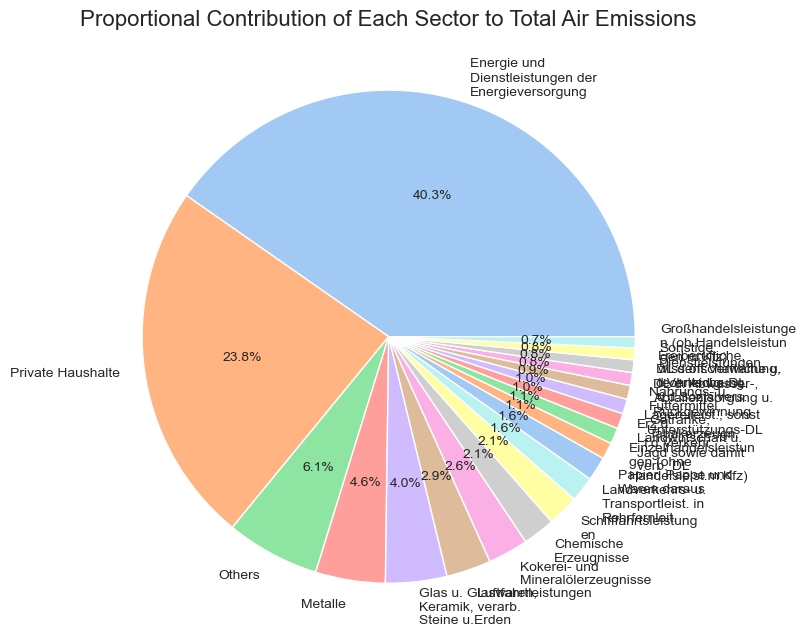

In [52]:
palette = sns.color_palette("pastel")
sns.set_style("dark")
plt.figure(figsize=(7, 7))

wrapped_labels = [ '\n'.join(wrap(label, 20)) for label in year_dict[2005]["economic_sector"] ]
plt.pie(year_dict[2005]["proportions"], labels=wrapped_labels, colors=palette, autopct='%1.1f%%')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Proportional Contribution of Each Sector to Total Air Emissions', fontsize=16, pad=30) 
plt.show()

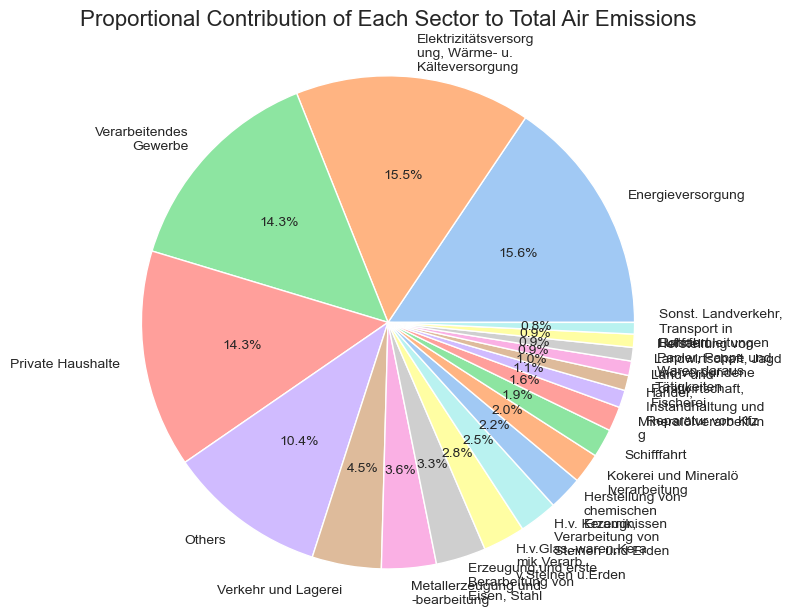

In [53]:
palette = sns.color_palette("pastel")
sns.set_style("dark")
plt.figure(figsize=(7, 7))

wrapped_labels = [ '\n'.join(wrap(label, 20)) for label in year_2020["economic_sector"] ]
plt.pie(year_2020["proportions"], labels=wrapped_labels, colors=palette, autopct='%1.1f%%')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Proportional Contribution of Each Sector to Total Air Emissions', fontsize=16, pad=20) 
plt.show()

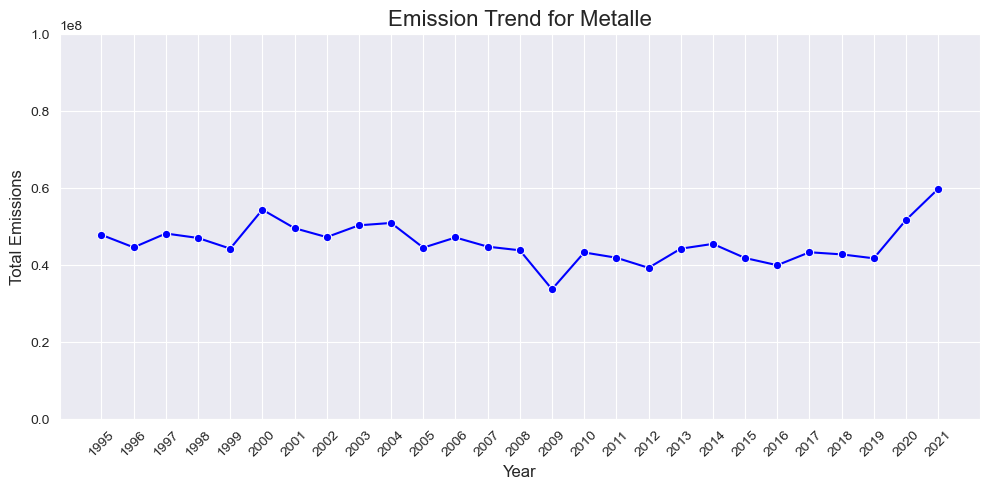

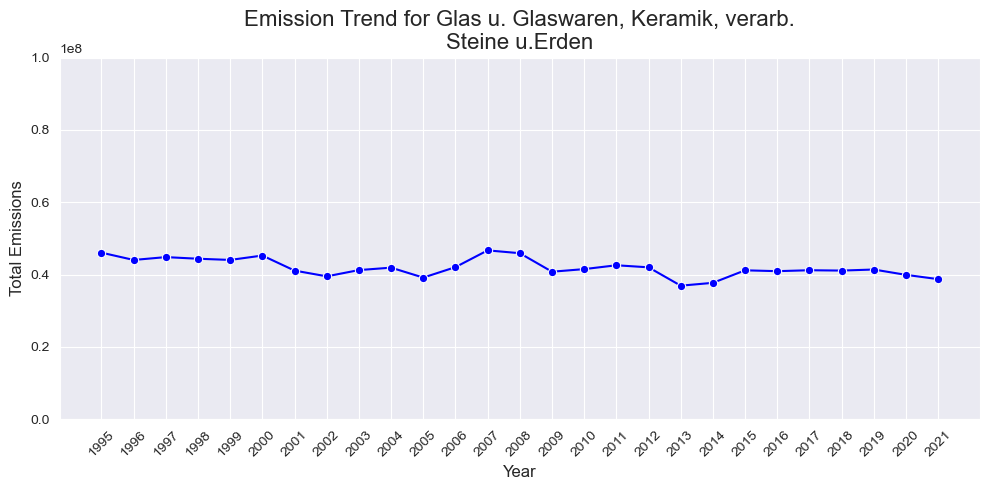

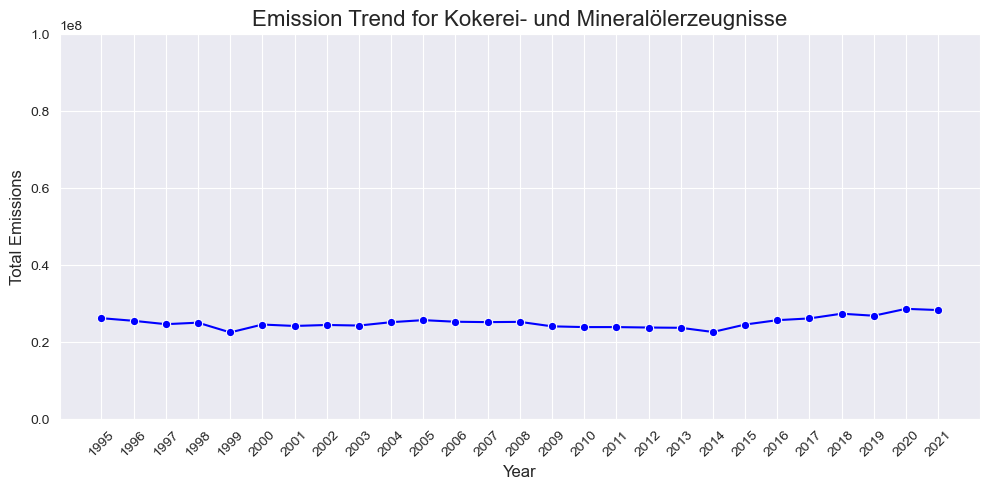

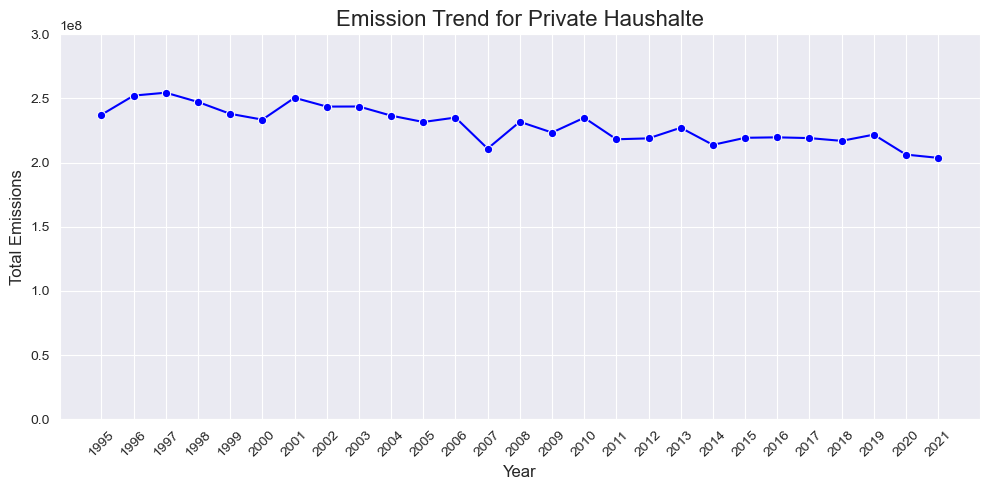

In [55]:
# We can compare some sectors from 2020 and 2021 by manually altering the sector names.

copy_2020 = year_2020.copy()
copy_2020['economic_sector'] = copy_2020['economic_sector'].replace('H.v.Glas,-waren,Keramik,Verarb. v.Steinen u.Erden', 'Glas u. Glaswaren, Keramik, verarb. Steine u.Erden')
copy_2020['economic_sector'] = copy_2020['economic_sector'].replace('Metallerzeugung und -bearbeitung', 'Metalle')
copy_2020['economic_sector'] = copy_2020['economic_sector'].replace('Kokerei und Mineralölverarbeitung', 'Kokerei- und Mineralölerzeugnisse')
copy_2020['economic_sector'] = copy_2020['economic_sector'].replace('Herstellung von chemischen Erzeugnissen', 'Chemische Erzeugnisse')
copy_2020['economic_sector'] = copy_2020['economic_sector'].replace('Schifffahrt', 'Schifffahrtsleistungen')


copy_2021 = year_2021.copy()

copy_2021['economic_sector'] = copy_2021['economic_sector'].replace('H.v.Glas,-waren,Keramik,Verarb. v.Steinen u.Erden', 'Glas u. Glaswaren, Keramik, verarb. Steine u.Erden')
copy_2021['economic_sector'] = copy_2021['economic_sector'].replace('Metallerzeugung und -bearbeitung', 'Metalle')
copy_2021['economic_sector'] = copy_2021['economic_sector'].replace('Kokerei und Mineralölverarbeitung', 'Kokerei- und Mineralölerzeugnisse')
copy_2021['economic_sector'] = copy_2021['economic_sector'].replace('Herstellung von chemischen Erzeugnissen', 'Chemische Erzeugnisse')
copy_2021['economic_sector'] = copy_2021['economic_sector'].replace('Schifffahrt', 'Schifffahrtsleistungen')


year_dict[2020] = copy_2020
year_dict[2021] = copy_2021
_ = visualize_trend(year_dict, "Metalle", 1e8)
_ = visualize_trend(year_dict, "Glas u. Glaswaren, Keramik, verarb. Steine u.Erden", 1e8)
_ = visualize_trend(year_dict, "Kokerei- und Mineralölerzeugnisse", 1e8)
_ = visualize_trend(year_dict, "Private Haushalte", 3e8)



